Test compositional lotka volterra algorithm on human gut time series (female test person).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import torch
import math
from scipy.io import loadmat

# from scipy.special import logsumexp
# from scipy.stats import pearsonr
# from scipy.stats import norm

from compositional_lotka_volterra_alr import *

# Import dataset

### Read data

In [2]:
# tax_level = "Order"
time_type = "hourly" # "daily", "hourly", "all" 

# path of data file
# filename = f"ts_Silverman_Vall_{time_type}_rel_counts_{tax_level}Level_most_abundant_only_relevant.csv"
filename = f"ts_Silverman_Vall_{time_type}_Genus_10_most_abundant_rel_counts.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/final_datasets/"

In [3]:
# function to import the datafile and put it into the right format
def create_data():
    ts_all = []
    data_all = []
    names_all = []
    data = pd.read_csv(f'{filepath}{filename}', sep=",", header=0)
    names = list(data.columns)[1:]
    usol = data.to_numpy()
    ts = usol[:, 0]
    data_y = usol[:, 1:]
    ts_all.append(ts)
    data_all.append(data_y)
    names_all.append(names)
    print(f"shape of {time_type} samples", data_y.shape)
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    return ts_all, data_all, names_all

In [4]:
T, Y, Names = create_data()

shape of hourly samples (117, 11)


### Adjust data

In [5]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [6]:
Y = adjust_concentrations(Y) 
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

In [7]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

### Plot data

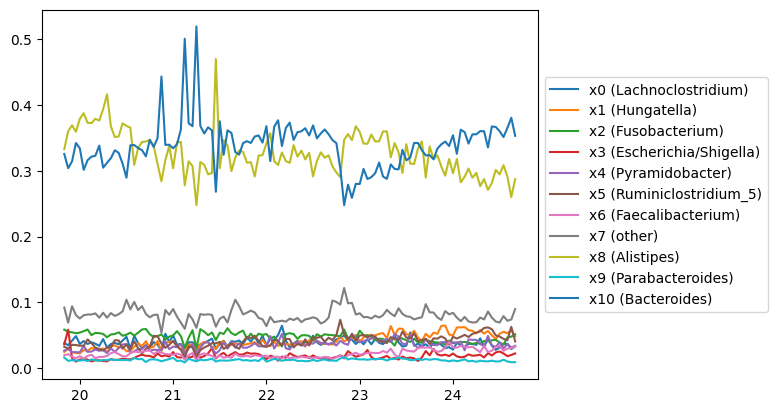

In [8]:
# plot time series with all taxa
fig, ax = plt.subplots()
for i in np.arange(n_taxa):
    ax.plot(T[0], P[0][:,i], label = f"x{i} ({Names[0][i]})")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(-0.01, 1.01)
plt.show()

In [9]:
print(n_taxa)
print(choose_denom(P))

11
8


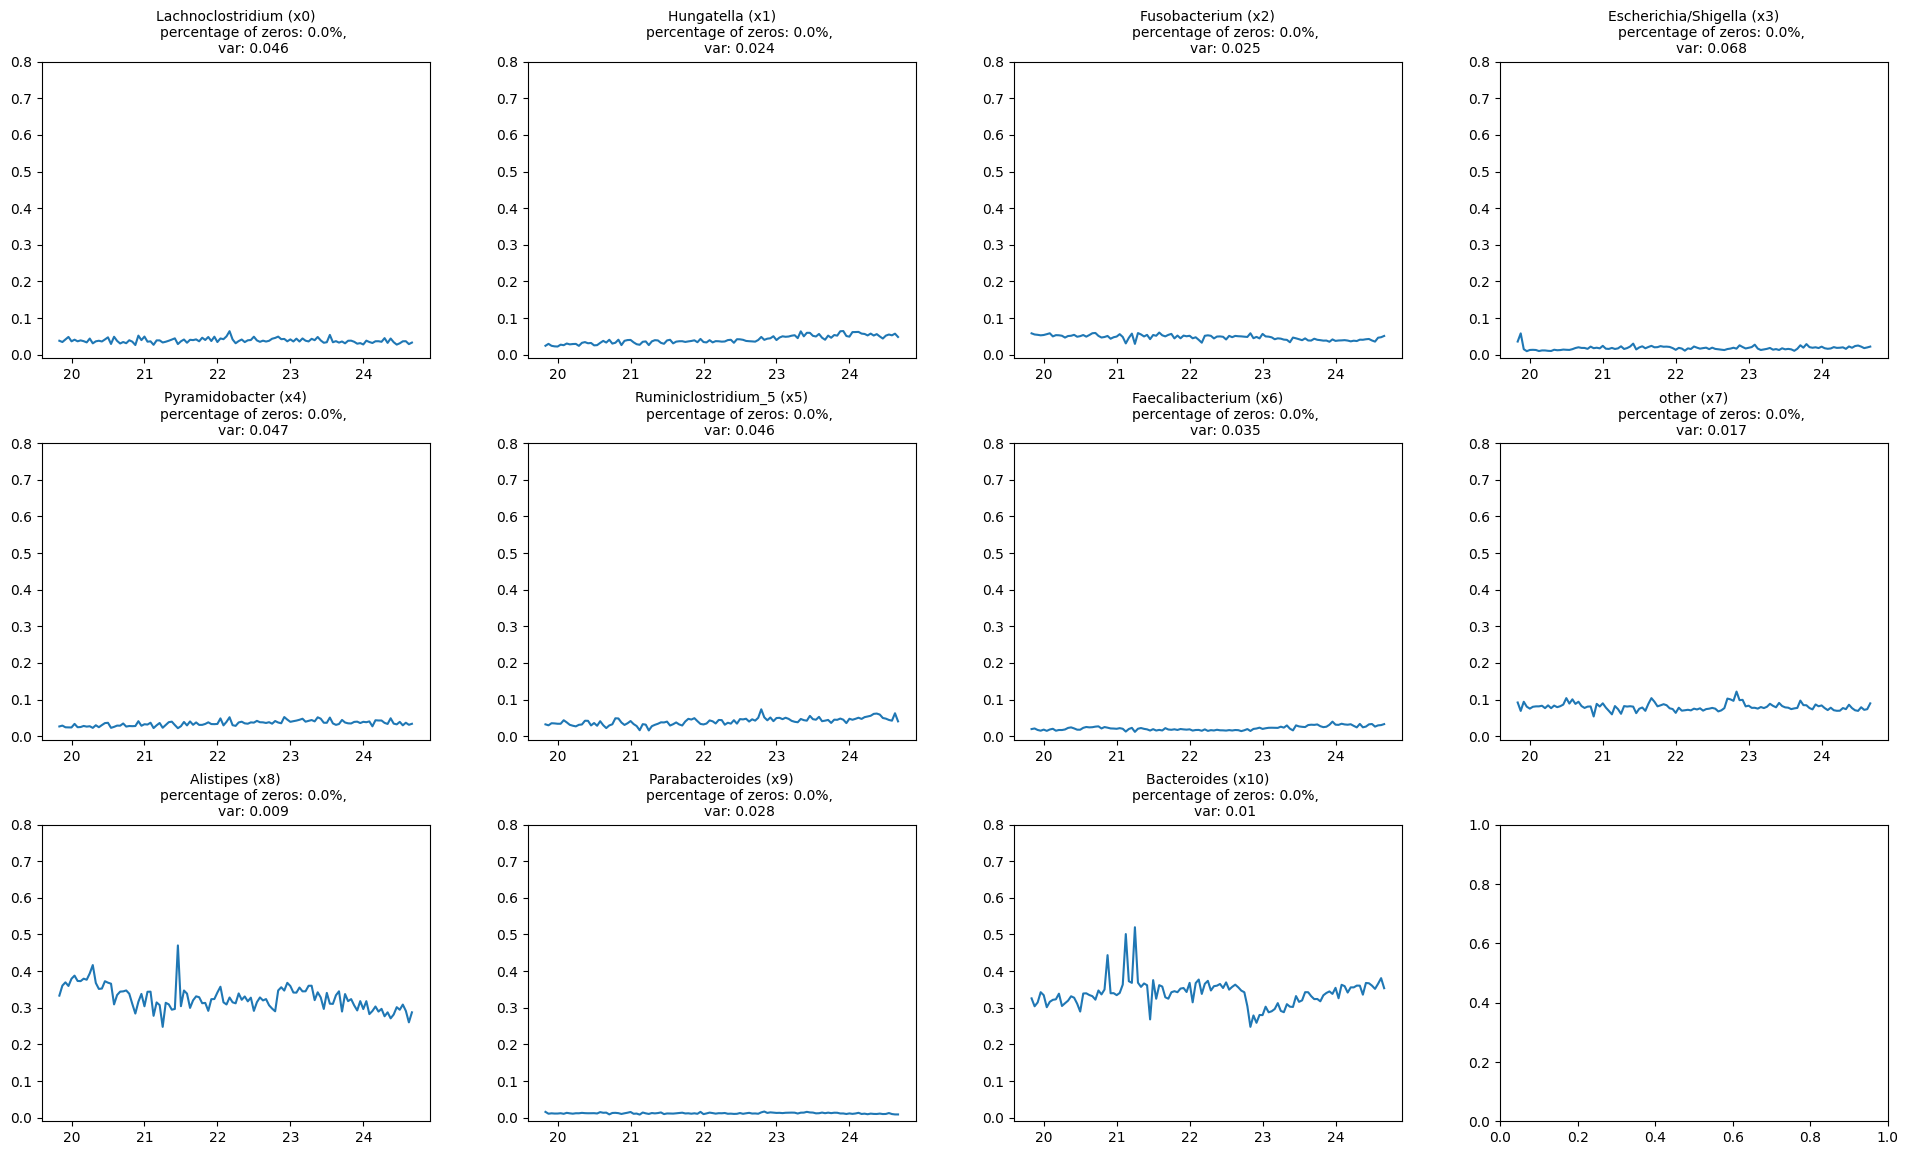

In [10]:
n_row = 3
n_col = 4
# plot time series with all otus
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.tight_layout(pad=4.0)
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(i/n_col), (i%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(i/n_col), (i%n_col)].set_title(f"""{Names[0][i]} (x{i})
        percentage of zeros: {round(sum(Y[0][:,i] == 0)/n_samples*100, 1)}%,
        var: {round(vars[i],3)}""")
    axs[math.floor(i/n_col), (i%n_col)].title.set_size(10)
    axs[math.floor(i/n_col), (i%n_col)].set_ylim([-0.01, 0.8])

### Perform ALR transformation

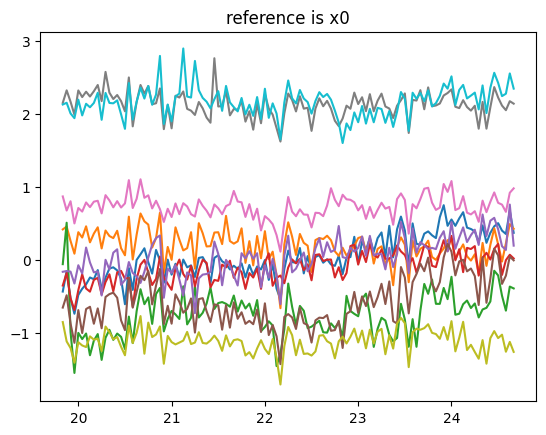

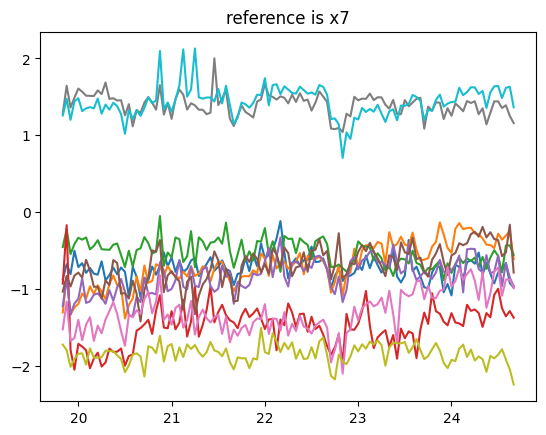

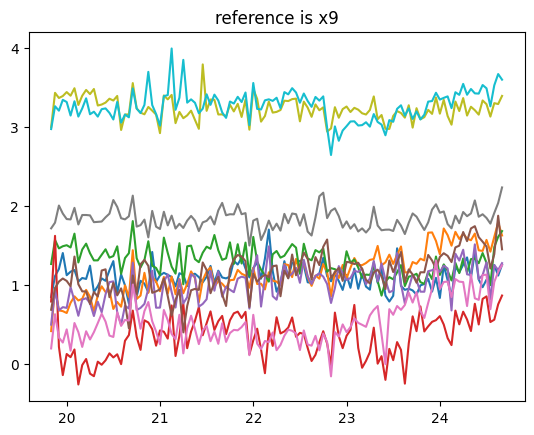

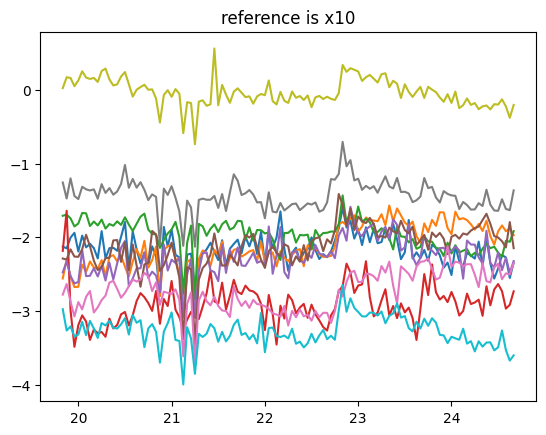

In [11]:
# plot data after alr for transformation with every otu as denominator
for denom_tmp in [0, 7, 9, 10]:
    ALR_tmp = construct_alr(P, denom_tmp)
    # plot alr
    fig, ax = plt.subplots()
    for i in np.arange(n_taxa-1):
        ax.plot(T[0], ALR_tmp[0][:,i]) #, label = f"x{i+1}"
    # ax.plot(T[0], Y[0][:, denom_tmp], color='black', linewidth=2)
    # ax.legend()
    ax.set_title(f"reference is x{denom_tmp}")

### choose final denominator and do alr transformation

In [12]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = Names[0].index("other") # for 10_most_abundant_rel_counts datasets
print(denom)

ALR = construct_alr(P, denom)

7


In [13]:
denom_name = Names[0].pop(denom)

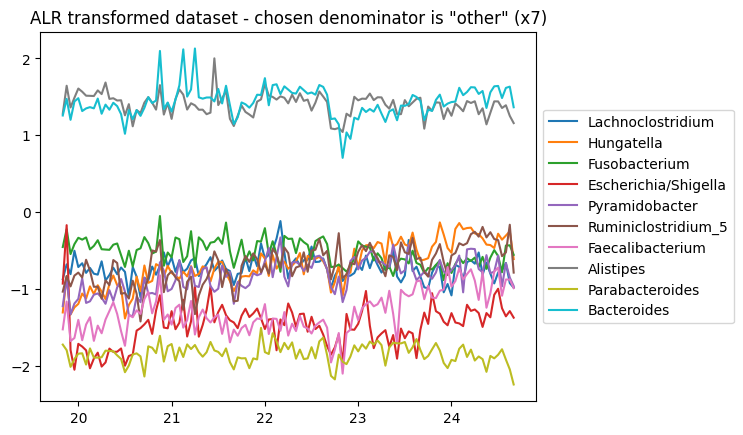

In [14]:
# plot alr transformed time series
fig, ax = plt.subplots()
for i in np.arange(n_taxa-1):
    ax.plot(T[0], ALR[0][:,i], label = Names[0][i])
ax.set_title(f'ALR transformed dataset - chosen denominator is \"{denom_name}\" (x{denom})')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### save ALR as csv file

In [15]:
# select folderpath for output
folderpath_out = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/Python/ALR_transformation/ALR_transformed_data/"

# save alr as csv file
df_ALR = pd.DataFrame(data=ALR[0], columns=Names[0])
df_ALR.insert(0, "Time", T[0])
df_ALR.to_csv(f'{folderpath_out}ALR_denom-{denom}-{denom_name}_{filename}', index=False)